# Setup Environment

If you are working on this assignment using Google Colab, please execute the codes below.

In [1]:
#@title Mount your Google Drive

import os
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
#@title Set up mount symlink

DRIVE_PATH = '/content/gdrive/My\ Drive/cs182hw3_sp23'
DRIVE_PYTHON_PATH = DRIVE_PATH.replace('\\', '')
if not os.path.exists(DRIVE_PYTHON_PATH):
  %mkdir $DRIVE_PATH

## the space in `My Drive` causes some issues,
## make a symlink to avoid this
SYM_PATH = '/content/cs182hw3'
if not os.path.exists(SYM_PATH):
  !ln -s $DRIVE_PATH $SYM_PATH

In [3]:
#@title Install dependencies

!pip install numpy==1.21.6 imageio==2.9.0 matplotlib==3.2.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
#@title Clone homework repo

%cd $SYM_PATH
if not os.path.exists("cs182hw3"):
  !git clone https://github.com/Berkeley-CS182/cs182hw3.git
%cd cs182hw3

/content/gdrive/My Drive/cs182hw3_sp23
/content/gdrive/My Drive/cs182hw3_sp23/cs182hw3


In [5]:
#@title Configure Jupyter Notebook

import matplotlib
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Train Convolutional Neural Networks using PyTorch

In this notebook we will put everything together you've learned: affine layers, relu layers, conv layers, max-pooling, (spatial) batch norm, and dropout, and train CNNs on CIFAR-100.

However, our implementation of these modules in NumPy are quite inefficient---especially convolutional layers. Therefore, we use PyTorch with GPU in this coding assignment.

Make sure you have access to GPUs when running this notebook. On Google Colab, you can switch to a GPU runtime by clicking "Runtime" - "Change Runtime Type" - "GPU" in the menu on the top of the webpage.

In [6]:
import os
import json
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils as utils
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

os.makedirs("submission_logs", exist_ok=True)

In [7]:
torch.cuda.is_available()
# make sure GPU is enabled

True

In [8]:
seed = 227

## Load and Visualize Data
In this cell, we load and visualize the CIFAR100 dataset. Note that we apply data augmentation (random horizontal flip) to the training dataset:
```pythontransforms.RandomHorizontalFlip()```
Data augmentation is a popular technique in machine learning and computer vision that involves generating additional training data to improve the performance of a model. One common form of data augmentation for image data is random horizontal flipping, which involves flipping an image horizontally with a 50% chance during training. This technique is often used to increase the variability of the training data and to help the model generalize better to new, unseen images. By randomly flipping images, the model is exposed to a wider range of orientations and can better learn to recognize features that are invariant to horizontal flipping.

In [9]:
valid_test_transform = transforms.Compose(
    [
        transforms.ToTensor(),   # convert image to PyTorch Tensor
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        # normalize to [-1.0, 1.0] (originally [0.0, 1.0])
    ]
)

train_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        transforms.RandomHorizontalFlip()   # data augmentation
    ]
)

# Download training data from open datasets.
training_data = datasets.CIFAR100(
    root="data",
    train=True,
    download=True,
    transform=train_transform,
)

# Download test data from open datasets.
valid_test_data = datasets.CIFAR100(
    root="data",
    train=False,
    download=True,
    transform=valid_test_transform,
)

# split original test data to valid data and test data
valid_data = list(valid_test_data)[::2]
test_data = list(valid_test_data)[1::2]

classes = [
    "apple",
    "aquarium_fish",
    "baby",
    "bear",
    "beaver",
    "bed",
    "bee",
    "beetle",
    "bicycle",
    "bottle",
    "bowl",
    "boy",
    "bridge",
    "bus",
    "butterfly",
    "camel",
    "can",
    "castle",
    "caterpillar",
    "cattle",
    "chair",
    "chimpanzee",
    "clock",
    "cloud",
    "cockroach",
    "couch",
    "cra",
    "crocodile",
    "cup",
    "dinosaur",
    "dolphin",
    "elephant",
    "flatfish",
    "forest",
    "fox",
    "girl",
    "hamster",
    "house",
    "kangaroo",
    "keyboard",
    "lamp",
    "lawn_mower",
    "leopard",
    "lion",
    "lizard",
    "lobster",
    "man",
    "maple_tree",
    "motorcycle",
    "mountain",
    "mouse",
    "mushroom",
    "oak_tree",
    "orange",
    "orchid",
    "otter",
    "palm_tree",
    "pear",
    "pickup_truck",
    "pine_tree",
    "plain",
    "plate",
    "poppy",
    "porcupine",
    "possum",
    "rabbit",
    "raccoon",
    "ray",
    "road",
    "rocket",
    "rose",
    "sea",
    "seal",
    "shark",
    "shrew",
    "skunk",
    "skyscraper",
    "snail",
    "snake",
    "spider",
    "squirrel",
    "streetcar",
    "sunflower",
    "sweet_pepper",
    "table",
    "tank",
    "telephone",
    "television",
    "tiger",
    "tractor",
    "train",
    "trout",
    "tulip",
    "turtle",
    "wardrobe",
    "whale",
    "willow_tree",
    "wolf",
    "woman",
    "worm",
]

  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting data/cifar-100-python.tar.gz to data
Files already downloaded and verified


In [10]:
# Create data loaders.
valid_dataloader = utils.data.DataLoader(valid_data, batch_size=5)

for X, y in valid_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([5, 3, 32, 32])
Shape of y: torch.Size([5]) torch.int64


Here is a visualization of 5 images in the validation dataset:

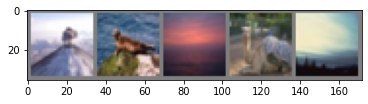

mountain   seal    sea     camel   cloud


In [11]:
# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(valid_dataloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print('   '.join(f'{classes[labels[j]]:5s}' for j in range(5)))

## Define the Neural Network Architecture

**Complete the code in `dl_pytorch/model.py`** to finish the implementation of a convolutional neural network with batch normalization and dropout.

In [12]:
from dl_pytorch.model import NeuralNetwork

model = NeuralNetwork()
print(model)

assert len(model.state_dict()) == 10
assert model.conv1.weight.shape == torch.Size([16, 3, 3, 3])
assert model.conv1.bias.shape == torch.Size([16])
assert model.conv2.weight.shape == torch.Size([32, 16, 3, 3])
assert model.conv2.bias.shape == torch.Size([32])
assert model.conv3.weight.shape == torch.Size([64, 32, 3, 3])
assert model.conv3.bias.shape == torch.Size([64])
assert model.fc1.weight.shape == torch.Size([256, 1024])
assert model.fc1.bias.shape == torch.Size([256])
assert model.fc2.weight.shape == torch.Size([100, 256])
assert model.fc2.bias.shape == torch.Size([100])
assert model(torch.randn(9, 3, 32, 32)).shape == torch.Size([9, 100])

model = NeuralNetwork(do_batchnorm=True, p_dropout=0.1)
assert len(model.state_dict()) == 25
assert model.bn1.weight.shape == model.bn1.bias.shape == torch.Size([16])
assert model.bn2.weight.shape == model.bn2.bias.shape == torch.Size([32])
assert model.bn3.weight.shape == model.bn3.bias.shape == torch.Size([64])
assert model(torch.randn(11, 3, 32, 32)).shape == torch.Size([11, 100])

NeuralNetwork(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (relu3): ReLU()
  (fc1): Linear(in_features=1024, out_features=256, bias=True)
  (relu4): ReLU()
  (fc2): Linear(in_features=256, out_features=100, bias=True)
)


## Train the Neural Network

Complete the code cells below to train your neural network.

In [15]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.cuda(), y.cuda()

        pred = model(X)
        loss = loss_fn(pred, y)

        ########################################################################
        # TODO: complete the following code for backpropagation and gradient
        #  update of a single step.
        # Hint: 3 lines
        ########################################################################
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        ########################################################################

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [16]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.cuda(), y.cuda()
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Evaluation Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return 100*correct

In [17]:
def get_optimizer(params, optim_type, lr, momentum, lr_decay, l2_reg):
    if optim_type == "sgd":
        optimizer = optim.SGD(params, lr=lr, momentum=0.0, weight_decay=l2_reg)
    elif optim_type == "sgd_momentum":
        optimizer = optim.SGD(params, lr=lr, momentum=momentum,
                              weight_decay=l2_reg)
    elif optim_type == "adam":
        optimizer = optim.AdamW(params, lr=lr, betas=(momentum, 0.999),
                                weight_decay=l2_reg)
    else:
        raise ValueError(optim_type)
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, lr_decay)
    return optimizer, scheduler

Train the neural network. It should achieve at least 35% accuracy on the test set.

In [18]:
def run_training(hp, nn_cls, save_prefix):
    print("Hyperparameters:", hp)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)

    model = nn_cls(do_batchnorm=hp.do_batchnorm, p_dropout=hp.p_dropout).cuda()

    # Create data loaders.
    train_dataloader = utils.data.DataLoader(
        training_data, batch_size=hp.batch_size)
    valid_dataloader = utils.data.DataLoader(
        valid_data, batch_size=hp.batch_size)
    
    loss_fn = nn.CrossEntropyLoss()
    optimizer, scheduler = get_optimizer(
        model.parameters(), hp.optim_type, hp.lr, hp.momentum, hp.lr_decay,
        hp.l2_reg)
    
    for t in range(hp.epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        train(train_dataloader, model, loss_fn, optimizer)
        test(valid_dataloader, model, loss_fn)
        scheduler.step()

    
    print(f"Saving the model to submission_logs/{save_prefix}.pt")
    torch.save(model.state_dict(), f"submission_logs/{save_prefix}.pt")
    return model

def eval_on_test(hp, model, save_prefix):
    train_dataloader = utils.data.DataLoader(
        training_data, batch_size=hp.batch_size)
    test_dataloader = utils.data.DataLoader(
        test_data, batch_size=hp.batch_size)
    loss_fn = nn.CrossEntropyLoss()
    print("Evaluating on the test set")
    test_acc = test(test_dataloader, model, loss_fn)
    n_params = sum(p.numel() for p in model.parameters())
    print("Parameter count: {}".format(n_params))
    n_steps = len(train_dataloader) * hp.epochs
    print("Training steps: {}".format(n_steps))
    with open(f"submission_logs/{save_prefix}.json", "w", encoding="utf-8") as f:
        json.dump({
            "test_acc": test_acc,
            "hparams": hp.__dict__,
            "n_params": n_params,
            "n_steps": n_steps
        }, f)

In [19]:
from dl_pytorch.hparams import HP as hp_base

model = run_training(hp_base, NeuralNetwork, "model")
eval_on_test(hp_base, model, "model")

Hyperparameters: Namespace(batch_size=32, do_batchnorm=False, epochs=5, l2_reg=0.0, lr=0.001, lr_decay=0.99, momentum=0.9, optim_type='adam', p_dropout=0.0)
Epoch 1
-------------------------------
loss: 4.607782  [    0/50000]
loss: 4.338592  [ 3200/50000]
loss: 4.088682  [ 6400/50000]
loss: 3.772011  [ 9600/50000]
loss: 3.786103  [12800/50000]
loss: 4.372434  [16000/50000]
loss: 3.318334  [19200/50000]
loss: 3.972894  [22400/50000]
loss: 3.278667  [25600/50000]
loss: 3.663373  [28800/50000]
loss: 3.213702  [32000/50000]
loss: 3.367341  [35200/50000]
loss: 3.254165  [38400/50000]
loss: 3.477012  [41600/50000]
loss: 2.768730  [44800/50000]
loss: 3.138325  [48000/50000]
Evaluation Error: 
 Accuracy: 23.4%, Avg loss: 3.120963 

Epoch 2
-------------------------------
loss: 3.136131  [    0/50000]
loss: 3.421011  [ 3200/50000]
loss: 3.315967  [ 6400/50000]
loss: 3.062536  [ 9600/50000]
loss: 2.703354  [12800/50000]
loss: 3.400100  [16000/50000]
loss: 2.725698  [19200/50000]
loss: 3.356939 

Train the neural network with batch norm and dropout. It should achieve at least 38% accuracy on the test set.

In [20]:
from dl_pytorch.hparams_bn_drop import HP as hp_bn_drop

model = run_training(hp_bn_drop, NeuralNetwork, "model_bn_drop")
eval_on_test(hp_bn_drop, model, "model_bn_drop")

Hyperparameters: Namespace(batch_size=32, do_batchnorm=True, epochs=5, l2_reg=0.0, lr=0.001, lr_decay=0.99, momentum=0.9, optim_type='adam', p_dropout=0.2)
Epoch 1
-------------------------------
loss: 4.662846  [    0/50000]
loss: 4.140881  [ 3200/50000]
loss: 3.924856  [ 6400/50000]
loss: 3.540820  [ 9600/50000]
loss: 3.335564  [12800/50000]
loss: 3.757537  [16000/50000]
loss: 3.163190  [19200/50000]
loss: 3.669087  [22400/50000]
loss: 3.267647  [25600/50000]
loss: 3.399520  [28800/50000]
loss: 3.172899  [32000/50000]
loss: 3.015152  [35200/50000]
loss: 2.828265  [38400/50000]
loss: 3.153431  [41600/50000]
loss: 3.043505  [44800/50000]
loss: 2.828578  [48000/50000]
Evaluation Error: 
 Accuracy: 29.7%, Avg loss: 2.829384 

Epoch 2
-------------------------------
loss: 3.315791  [    0/50000]
loss: 3.000919  [ 3200/50000]
loss: 3.332176  [ 6400/50000]
loss: 2.885189  [ 9600/50000]
loss: 2.533549  [12800/50000]
loss: 2.968091  [16000/50000]
loss: 2.760545  [19200/50000]
loss: 2.993144  

## Design your own neural network


It's time to showcase your deep learning skills! In this assignment, you will be designing your own neural network using PyTorch. Your task is to **implement your neural network design in the files `dl_pytorch/my_model.py` and `dl_pytorch/hparams_my_model.py`**. The goal is to achieve a test accuracy of **44%** or higher.

To ensure reproducibility and to maintain the focus of the assignment, please adhere to the following rules:

1. Do not modify the code in the Jupyter Notebook cell or other cells that this cell depends on. It means that you cannot change data processing, the training loop, and the random seed. The emphasis of this assignment is on the model architecture and hyperparameter tuning.

1. The number of model parameters must not exceed `1,000,000`.

1. The total number of training steps should be no more than `20,000`.

1. The maximum number of training epochs is `10`.

1. Please refrain from using any pre-trained models or other downloaded assets.

Your test accuracy will be displayed on the Gradescope leaderboard. Please note that your rank on the leaderboard does not affect your grade. In order to receive full credit for this part of the assignment, you only need to abide by the rules outlined above and achieve a minimum test accuracy of 44%. Your grade will be scaled linearly, with a score of 0 for a test accuracy of 38% and full credit for a test accuracy of 44% or higher.

In [21]:
from dl_pytorch.my_model import MyNeuralNetwork
from dl_pytorch.hparams_my_model import HP as hp_my_model

model = run_training(hp_my_model, MyNeuralNetwork, "model_my_model")

Hyperparameters: Namespace(batch_size=32, do_batchnorm=True, epochs=5, l2_reg=0.0, lr=0.001, lr_decay=0.99, momentum=0.9, optim_type='adam', p_dropout=0.2)
Epoch 1
-------------------------------
loss: 4.887371  [    0/50000]
loss: 4.285199  [ 3200/50000]
loss: 4.362989  [ 6400/50000]
loss: 3.876976  [ 9600/50000]
loss: 3.919739  [12800/50000]
loss: 4.429490  [16000/50000]
loss: 3.587250  [19200/50000]
loss: 3.974435  [22400/50000]
loss: 3.460201  [25600/50000]
loss: 3.967312  [28800/50000]
loss: 3.613081  [32000/50000]
loss: 3.334165  [35200/50000]
loss: 2.987887  [38400/50000]
loss: 3.162585  [41600/50000]
loss: 3.231714  [44800/50000]
loss: 2.942695  [48000/50000]
Evaluation Error: 
 Accuracy: 21.7%, Avg loss: 3.167471 

Epoch 2
-------------------------------
loss: 3.516046  [    0/50000]
loss: 3.081623  [ 3200/50000]
loss: 2.966256  [ 6400/50000]
loss: 3.022560  [ 9600/50000]
loss: 2.748192  [12800/50000]
loss: 3.146186  [16000/50000]
loss: 2.623596  [19200/50000]
loss: 3.203952  

In [22]:
# When you are ready to eval on test set, run this cell
# WARNING: In real-world applications, it is a bad practice to evaluate
#          frequently on the test set because the model will then perform poorly
#          on new, unseen data even if it achieves a high test accuracy.
eval_on_test(hp_my_model, model, "model_my_model")

Evaluating on the test set
Evaluation Error: 
 Accuracy: 48.0%, Avg loss: 1.934452 

Parameter count: 486596
Training steps: 7815


### Question:

**Briefly design your neural network design and the procedure of hyperparameter tuning.** Please include the answer of this question in your written assignment.

# Collect your submissions

The following command will collect your solutions generated by both notebooks.

On Colab, after running the following cell, you can download your submissions from the `Files` tab, which can be opened by clicking the file icon on the left hand side of the screen.

In [24]:
!rm -f cs182hw3_submission.zip
!zip -r cs182hw3_submission.zip . -x "*.git*" "*deeplearning/datasets*" "data*" "*.ipynb_checkpoints*" "*README.md" ".env/*" "*.pyc" "*deeplearning/build/*" "*__pycache__/*"

  adding: deeplearning/ (stored 0%)
  adding: deeplearning/__init__.py (stored 0%)
  adding: deeplearning/classifiers/ (stored 0%)
  adding: deeplearning/classifiers/__init__.py (stored 0%)
  adding: deeplearning/classifiers/cnn.py (deflated 73%)
  adding: deeplearning/classifiers/fc_net.py (deflated 79%)
  adding: deeplearning/data_utils.py (deflated 68%)
  adding: deeplearning/gradient_check.py (deflated 68%)
  adding: deeplearning/optim.py (deflated 76%)
  adding: deeplearning/solver.py (deflated 69%)
  adding: deeplearning/vis_utils.py (deflated 65%)
  adding: deeplearning/layer_utils.py (deflated 81%)
  adding: deeplearning/layers.py (deflated 81%)
  adding: dl_pytorch/ (stored 0%)
  adding: dl_pytorch/hparams.py (deflated 32%)
  adding: dl_pytorch/hparams_bn_drop.py (deflated 31%)
  adding: dl_pytorch/hparams_my_model.py (deflated 58%)
  adding: dl_pytorch/model.py (deflated 76%)
  adding: dl_pytorch/my_model.py (deflated 79%)
  adding: hw3_bn_drop_cnn.ipynb (deflated 78%)
  addi